### Read MNIST Dataset

In [1]:
import gzip
import numpy as np

## Data from: http://yann.lecun.com/exdb/mnist/

# the images were centered in a 28x28 image by computing the center of mass of the pixels
# , and translating the image so as to position this point at the center of the 28x28 field.
image_size = 28
# 60000 train images available
num_images = 60000 

f = gzip.open('MNIST/train-images-idx3-ubyte.gz','r')
f.read(16)
buf = f.read(image_size * image_size * num_images)
training_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
X_train = training_data.reshape(num_images, image_size, image_size, 1)

In [2]:
len(X_train), X_train[0].shape

(60000, (28, 28, 1))

In [3]:
f = gzip.open('MNIST/train-labels-idx1-ubyte.gz','r')
f.read(8)
y_train = np.frombuffer(f.read(60000), dtype=np.uint8).astype(np.float32)

In [4]:
len(y_train), y_train.shape

(60000, (60000,))

5.0


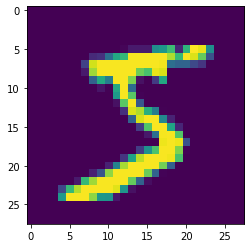

In [5]:
import matplotlib.pyplot as plt
image = np.asarray(X_train[0]).squeeze()
print(y_train[0])
plt.imshow(image)
plt.show()

In [6]:
for i in X_train[0].squeeze():
    print(' '.join(map(lambda x: str(int(x)), i)))

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 3 18 18 18 126 136 175 26 166 255 247 127 0 0 0 0
0 0 0 0 0 0 0 0 30 36 94 154 170 253 253 253 253 253 225 172 253 242 195 64 0 0 0 0
0 0 0 0 0 0 0 49 238 253 253 253 253 253 253 253 253 251 93 82 82 56 39 0 0 0 0 0
0 0 0 0 0 0 0 18 219 253 253 253 253 253 198 182 247 241 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 80 156 107 253 253 205 11 0 43 154 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 14 1 154 253 90 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 139 253 190 2 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 11 190 253 70 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 35 241 225 160 108 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 81 240 253 253 119 25 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0

### Build Layer

#### Sample with a 2D Array

We build a single convolutional neural network that is only able to take in a single image

Aiming to build only a CNN for greyscale here 

<img src="media/simple_cnn/architecture.png" width=500/>

### We follow the LeNet Architecture of the following: 

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Conv2D(filters = 6, kernel_size = (5,5), activation = "relu", input_shape = (28, 28, 1)))
model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(filters = 16, kernel_size = (5,5), activation = "relu"))
model.add(layers.AveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(units = 120, activation = "relu"))
model.add(layers.Dense(units = 84, activation = "relu"))
model.add(layers.Dense(units = 10, activation = "softmax"))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

##### Convolution

In [15]:
def convolution(input_array: np.array, _kernel_filter: np.array, layer_type: str = "input"):
    
    ''' Convolve over a greyscale image matrix
    
    input_array -> [np.array] : 2D numpy square matrix containing image
    _kernel_filter -> [np.array]: 3D filter containing layers of kernels
    
    '''
    
    filter_size = _kernel_filter.shape[0] ## Size of a single filter, how many kernels in a filter
    kernel_size = _kernel_filter.shape[1] ## Size of a single kernel
    mat_size = input_array.shape[1] ## Size of a single image 

    convolved_size = mat_size - _kernel_filter.shape[1] + 1 ## Size of single feature matrix after convolution

    convolved_matrix = np.zeros((filter_size, convolved_size, convolved_size)) ## Initialize the matrix for the input values
    
    for kernel_index in range(filter_size):
        kernel = _kernel_filter[kernel_index]
        for i in range(convolved_size):
            for j in range(convolved_size):
                if layer_type == 'input':
                    matrix_sum = np.sum(sample_data[i : i + kernel_size, j : j + kernel_size] * kernel)
                else:
                    matrix_sum = np.sum(sample_data[kernel_index, i : i + kernel_size, j : j + kernel_size] * kernel)
                convolved_matrix[kernel_index, i, j] = matrix_sum
    
    return convolved_matrix

##### Pooling

In [16]:
def max_pool(input_array: np.array, _pooling_filter: np.array, filter_size: int = 2, stride: int = 2):
    
    ''' Max pool over an input matrix 
    
    input_array -> [np.array] : 2D numpy square matrix containing image
    _pooling_filter -> [np.array]: 3D filter containing layers of kernels
    
    '''
    
    pooled_size = (input_array.shape[2] - filter_size)/stride + 1
    assert pooled_size % 1 == 0
    pooled_size = int(pooled_size)
    
    pooled_matrix = np.zeros((layers, pooled_size, pooled_size)) ## Initialize the matrix for the input values
    
    for pooling_index in range(layers):
        kernel = _pooling_filter[pooling_index]
        for i in range(0, input_array.shape[1], stride):
            for j in range(0, input_array.shape[1], stride):
                matrix_maximum = np.max(input_array[pooling_index, i : i + filter_size, j : j + filter_size]) ## Input array is 3D !
                pooled_matrix[pooling_index, i//stride, j//stride] = matrix_maximum
    
    return pooled_matrix

##### Run Convolution Portion of the network

In [61]:
from importlib import reload
import propnn
reload(propnn)

<module 'propnn' from '/Users/lohyikuang/Downloads/personal_projects/Robin/propnn.py'>

In [62]:
filter_size = 2
kernel_size = 5
layers = 10

conv_1_kernel_filter = np.random.random((layers, kernel_size, kernel_size))
conv_1_pooling_filter = np.random.random((layers,filter_size,filter_size))

conv_2_kernel_filter = np.random.random((layers, kernel_size, kernel_size))
conv_2_pooling_filter = np.random.random((layers,filter_size,filter_size))

In [63]:
conv_1 = propnn.Conv2D(sample_data, input_shape = (28,28,1))
conv_1.shape

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [20]:
pool_1 = max_pool(conv_1, conv_1_pooling_filter)
pool_1.shape

(10, 12, 12)

In [21]:
conv_2 = convolution(pool_1, conv_2_kernel_filter)
conv_2.shape

(10, 8, 8)

In [22]:
pool_2 = max_pool(conv_2, conv_2_pooling_filter)
pool_2.shape

(10, 4, 4)

In [23]:
pool_2

array([[[   0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,   13.23747982,  221.67059104,  449.99415983],
        [   0.        ,   43.50561582,  518.45153155, 1107.47294395],
        [   0.        ,   43.0326692 ,  823.51879309, 1930.3741725 ]],

       [[   0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,   46.42508776,  283.98922943,  689.58071654],
        [   0.        ,   53.18717825,  564.49997456, 1439.79407118],
        [   0.        ,   56.61701401,  640.02638241, 1636.23042096]],

       [[   0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,    9.14448429,  337.82840417,  876.82628587],
        [   0.        ,   23.49936202,  693.15374318, 1792.91572494],
        [   0.        ,   47.25986798,  674.53129598, 1935.73644705]],

       [[   0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,   17.55023947,  369.80541745,  744.26866313],
        [   0.